In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# ensure that any edits to libraries you make are reloaded here automatically,
# and also that any charts or images displayed are shown in this notebook.


import numpy as np
import scipy as sc
import sklearn as sk
from sklearn import datasets, linear_model, model_selection, metrics
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib as mpl
np.set_printoptions(precision=2)
plt.rcParams['figure.figsize'] = [12, 8]


import pmdarima as pm
from pmdarima import model_selection

import torch
import torch.nn as nn



import compare_models_functions as myfxns

# for each model, choose:
#test_size = 7 # how many days to predict = how many days to reserve for testing
#cases_or_deaths = 'cases'
#use_log_counts = True


cases_df, deaths_df = myfxns.load_county_datasets()



# make filtered dataset (currently do not use, only working with counts)
#X_df, X, y = filter_and_scale_data(cases_df, cases_or_deaths = 'cases', 
#    use_last_n_days=28,  max_frac_missing=0.1, 
#    use_rel_counts=False, use_log_counts = True, use_counts_only = False)





In [2]:
# LSTM, treating counties as independent
# TODO try passing in differences instead of raw counts

from sklearn.preprocessing import MinMaxScaler

import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

from torch.utils.data import DataLoader




class SeqDataset(torch.utils.data.Dataset):
    '''dataset that optionally maintains list of IDs for each sample (e.g. county name or fips).
    inputs, labels, and list_IDs must be in same order'''
    def __init__(self, inputs, labels, list_IDs=None):
        'Initialization'
        self.inputs = np.array(inputs) # assume 2D, each row is sample
        self.labels = np.array(labels) # assume 2D, each row is sample
        self.list_IDs = list_IDs
  
    def __len__(self):
        'Denotes the total number of samples'
        return self.inputs.shape[0]

    def __getitem__(self, index):
        'Generates one sample of data'
        
        X = self.inputs[index,:]
        y = self.labels[index,:]

        return X, y
    
    # could add option to look up ID of a datapoint, and make inputs and labels dictionary
    #ID = self.list_IDs[index]
    

    

In [124]:

# inputs small, try varying batch size

def train_lstm(train_dataset, batch_size=100, num_epochs=10, lr=0.05, 
               input_dim=1, hidden_dim=21, pred_seq_len=7):
    '''simple train function w batches w/o early stopping or checkpoints'''
    
    # currently drop last batch, could consider padding it
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, 
                              num_workers = 4, drop_last = True)
    
    #input_dim = 1 # number of features per timepoint/token
    #input_seq_len = 21 # length of input sequence/series

    model = LSTM(input_dim, hidden_dim, output_dim=pred_seq_len, batch_size=batch_size, num_layers=2, dropout=0.5)
    model = model.train().to(DEVICE)
    model = model.double() # set model to use double, otherwise float vs double error
    
    criterion = torch.nn.MSELoss() #L1Loss()    # for regression
    optimizer = torch.optim.SGD(model.parameters(), lr=lr) # can try other optimizer

    #num_batches = int(len(train_dataset) / float(batch_size)) + 1
    
    # TODO handle batches which aren't multiple of whole dataset
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get batch
            inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)
                        
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # update loss
            running_loss += loss.item()

        #End of epoch report
        if epoch % 1 == 0:
            print('[Epoch %d] loss: %.3f' %
                  (epoch + 1, running_loss/100 )) 
            # TODO get per item loss, porb fine since each epoch train same size

    print('Finished Training')
    
    return model


class LSTM(nn.Module):
 
    def __init__(self, input_dim, hidden_dim, batch_size=1, output_dim=1,
                    num_layers=10, dropout=0.2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim   # how many features per time point (or token)
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.output_dim = output_dim

        # lstm layers and linear layer to output single time point
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, 
                            dropout=self.dropout, batch_first=True)
        self.linear = nn.Linear(self.hidden_dim, self.output_dim)
 
    #def init_hidden(self): # use to reset hidden state
    #    hidden = (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
    #            torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
    #    return hidden # could also set self.hidden here


    def forward(self, inputs):
        # note: dim depends on whether lstm layer initialized with batch_first. 
        # Code assumes batch_first, unidirectional
        
        # nn.LSTM expects input shape ( timepoints, batch_size, features per timepoint)
        #        or (batch_size, timepoints, features per timepoint) if batch_first
        # lstm_out: (seq_len, batch, num_directions * hidden_size) 
        #        or (batch, seq_len, numdir*hidden_size)
        # self.hidden: tup of two (num_layers, batch_size, hidden_dim)
        #                     or (batch_size, num_layers, hidden_dim)
        lstm_out, self.hidden = self.lstm(inputs.view(self.batch_size, -1, self.input_dim)) 

        # linear layer takes output of final timestep
        # TODO should it take output or hidden?
        y_pred = self.linear(lstm_out[:,-1,:])
        return y_pred


In [133]:
# preprocess data for LSTM
# currently use 21 days to predict next 7 days, predict on holdout set of counties
# (only one sample per county)


# only use 28 days, and use all counties with 28 days
X_df, X, y = myfxns.filter_and_scale_data(cases_df, cases_or_deaths = 'cases', 
    use_last_n_days=28,  max_frac_missing=0.0, 
    use_rel_counts=False, use_log_counts = True, use_counts_only = True)

X = np.array(X_df.iloc[:,3:]) # each row county, each col is counts for 28 days

# split data (currently split into train/test counties, but could split into train/test days or both)
#n_test_counties = 500
Xtrain, Xtest = model_selection.train_test_split(X, test_size=0.25)
#Xtrain = X[:10,:] # TODO

pred_seq_len = 7
Xtrain_inputs = Xtrain[:,:-pred_seq_len]
Xtrain_labels = Xtrain[:,-pred_seq_len:] # predict last 7 days
Xtest_inputs = Xtest[:,:-pred_seq_len]
Xtest_labels = Xtest[:,-pred_seq_len:]


# normalize inputs (best practice for lstm)
# not sure if that is correct, since larger values may be seen in latest samples
scaler = MinMaxScaler()
scaler = scaler.fit(Xtrain_inputs)
Xtrain_inputs = scaler.transform(Xtrain_inputs)
Xtest_inputs = scaler.transform(Xtest_inputs)


DEVICE = torch.device('cpu') # use 'cpu' for debug, 'cuda' for run on gpu
print('Using device: ' + str(DEVICE))


# TODO, lost the county info in train/test split, could save it
train_dataset = SeqDataset(Xtrain_inputs, Xtrain_labels, list_IDs=None)
batch_size=10
model = train_lstm(train_dataset, num_epochs=20, batch_size=batch_size,lr=0.05, pred_seq_len = pred_seq_len)




Using device: cpu
[Epoch 1] loss: 6.242
[Epoch 2] loss: 2.765
[Epoch 3] loss: 1.145
[Epoch 4] loss: 0.418
[Epoch 5] loss: 0.312
[Epoch 6] loss: 0.313
[Epoch 7] loss: 0.223
[Epoch 8] loss: 0.182
[Epoch 9] loss: 0.209
[Epoch 10] loss: 0.166
[Epoch 11] loss: 0.171
[Epoch 12] loss: 0.139
[Epoch 13] loss: 0.144
[Epoch 14] loss: 0.137
[Epoch 15] loss: 0.145
[Epoch 16] loss: 0.141
[Epoch 17] loss: 0.137
[Epoch 18] loss: 0.140
[Epoch 19] loss: 0.133
[Epoch 20] loss: 0.121
Finished Training


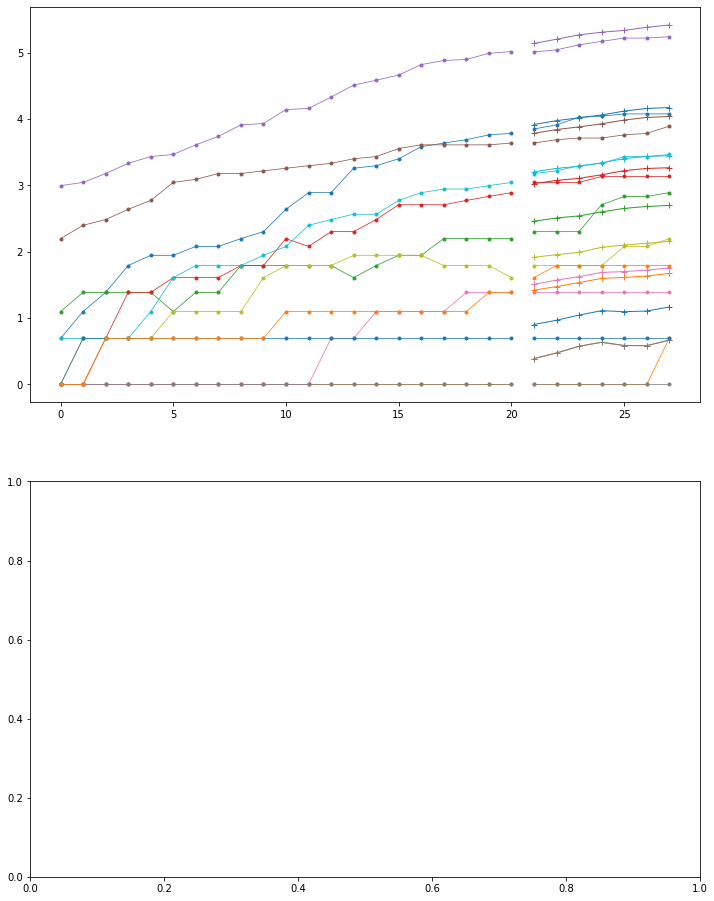

In [136]:
# predict on holdout set

model.double().to(DEVICE).eval()
#train_dataset = SeqDataset(Xtrain_inputs, Xtrain_labels, list_IDs=None)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False, 
                              num_workers = 4, drop_last = True)


test_dataset = SeqDataset(Xtest_inputs, Xtest_labels, list_IDs=None)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, 
                              num_workers = 4, drop_last = True)

preds_train = []
labels_train = []

fig, axs = plt.subplots(2, 1, sharex=False, sharey=False, figsize=(12,16))


for i, data in enumerate(test_loader, 0): # train_loader, 0):
    # only plot first sample from each batch
    inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)
    preds = model(inputs.double()).detach().numpy()
    # remember to untransform inputs
    inputs = scaler.inverse_transform(inputs.detach().numpy()) 
    labels = labels.detach().numpy()
    
    end_train = 28 - pred_seq_len
    p = axs[0].plot(range(end_train), inputs[0], marker='.', linewidth=0.75) # actual log(cases)
    color = p[0].get_color()
    end = 21+pred_seq_len
    axs[0].plot(range(end_train,28), labels[0], c=color, marker='.', linewidth=0.75) # actual log(cases), last week
    axs[0].plot(range(end_train, 28), preds[0], c=color, marker='+', linewidth=1) # pred log(cases), last week

    if i>10:
        break
    
plt.show()


In [5]:

# could do sliding window instead, feed output back in to predict future
# could predict multiple counties simultaneously
# could also pass in one-hot of exogenous data for each county


# split into input/output (last X days)
# TODO in training, use past 6 days to predict 7th day

#X_data = X_df.iloc[:,3:-7] # 21 days for each county
#X_labels = X_df.iloc[:,-7:] # last 7 days for each county
# currently about 1500 counties with 28 days of case data





def sliding_windows(data, seq_length):
    '''given 1d arr of timepoints, return array of sliding windows (x) and value immediately following (y)'''

    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)




In [ ]:
input = Variable(torch.randn(1, batch, num_hyperparams)) # (seq_len, batch, input_size)
h0 = Variable(torch.randn(num_layers, batch, hidden_size)) # (num_layers, batch, hidden_size)
c0 = Variable(torch.randn(num_layers, batch, hidden_size))
output, hn = rnn(input, (h0, c0))
affine1 = nn.Linear(hidden_size, num_hyperparams)


out_rnn, hn = rnn(input, (h0, c0))
lin = nn.Linear(hidden_size, output_size)
v1 = nn.View(seq_len*batch, hidden_size)
v2 = nn.View(seq_len, batch, output_size)
output = v2(lin(v1(out_rnn)))


pred_seq_len = 14


train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]

train_data.shape

"""We have to scale the data (values will be between 0 and 1) if we want to increase the training speed and performance of the model. We'll use the `MinMaxScaler` from scikit-learn:"""

scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

"""Currently, we have a big sequence of daily cases. We'll convert it into smaller ones:"""

def create_sequences(data, seq_length):
    '''conerts long seq to: 5 in, 1 out, sliding window (?)'''
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

"""Each training example contains a sequence of 5 data points of history and a label for the real value that our model needs to predict. Let's dive in:"""

X_train.shape

X_train[:2]

y_train.shape

y_train[:2]

train_data[:10]

In [ ]:
class CoronaVirusPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

"""Our `CoronaVirusPredictor` contains 3 methods:
- constructor - initialize all helper data and create the layers
- `reset_hidden_state` - we'll use a stateless LSTM, so we need to reset the state after each example
- `forward` - get the sequences, pass all of them through the LSTM layer, at once. We take the output of the last time step and pass it through our linear layer to get the prediction.

## Training

Let's build a helper function for the training of our model (we'll reuse it later):
"""

def train_model(
  model, 
  train_data, 
  train_labels, 
  test_data=None, 
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 60

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimiser.zero_grad()

    loss.backward()

    optimiser.step()
  
  return model.eval(), train_hist, test_hist

"""Note that the hidden state is reset at the start of each epoch. We don't use batches of data our model sees every example at once. We'll use mean squared error to measure our training and test error. We'll record both. 

Let's create an instance of our model and train it:
"""

model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model, 
  X_train, 
  y_train, 
  X_test, 
  y_test
)

"""Let's have a look at the train and test loss:"""

plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 5))
plt.legend();


In [ ]:
"""Our model's performance doesn't improve after 15 epochs or so. Recall that we have very little data. Maybe we shouldn't trust our model that much?

## Predicting daily cases

Our model can (due to the way we've trained it) predict only a single day in the future. We'll employ a simple strategy to overcome this limitation. Use predicted values as input for predicting the next days:
"""

with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

"""We have to reverse the scaling of the test data and the model predictions:"""

true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

"""Let's look at the results:"""

plt.plot(
  daily_cases.index[:len(train_data)], 
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  true_cases,
  label='Real Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  predicted_cases, 
  label='Predicted Daily Cases'
)

plt.legend();

In [ ]:
## prophet: bayesian curve fitting 
# this cell wip
# need to check if intended primarily for seasonal data
## has linear and logistic growth models



from fbprophet import Prophet
# https://facebook.github.io/prophet/docs/

m = Prophet()
m.fit(df)

future = m.make_future_dataframe(periods=??)
future.tail()

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()




#endogenous: response, dependent
#exogenous: predictor, independent



In [ ]:
# convert dates to numbers for plt
#x = matplotlib.dates.date2num(train_cases_df.columns[3:])

## linear model: regress log(deaths or cases) against demographics + interventions + counts
## linear model: regress log(deaths) against deaths in all counties on previous days
#            maybe too few sample - coeffs would be different for pred LA vs other county
# also try predicting raw deaths, increase in deaths, deaths per pop size
## rf, arima, curve fitting

## regression, arimax model. 
# delta log(cases_county_x) = beta * X_demographic + phi_(t-1) * cases_(all counties, t-1) + ....

In [ ]:
# TODO arima using other counties, deaths, state-level testing as exogenous 

# TODO add proportion or number tested as feature
# state-level data available here, including time series starting from feb 28:
# https://covidtracking.com/data

# TODO will output predictions from ARIMA and LSTM models in the prediction_csv/ directory
